# TPSA and python
We made a very simple example on how to program a TPSA example in Python.
The idea is to clarify the TPSA approach in itself and to remove the (possible) mistery around it. 
This notebook is based on https://agenda.infn.it/getFile.py/access?resId=0&materialId=slides&confId=2620 and http://bt.pa.msu.edu/pub/papers/pada/pada.pdf

### Introduction 
As child, we learnt how to count and in the first years of schools we learnt that instead of counting we can use the power of algebric operation to "count faster", to associate set of number with "+","-","*" and "/".

Example: if you merge two sets of 15 and 35 units then the total set has 50 units. You do not need to count the set after the merging but you apply just the "algebra".

Similarly in the high school we learnt the calculus and how to "count" derivative ("make an analytical derivative"). We did not learn the corresponding algebra of the derivatives (that is how to combine with basic operation different derivatives). 
TPSA is the algebra used for truncated power series and it can be directly linked to the computation of the derivatives.

Let us assume we want to compute the first derivative of the simple function
\begin{equation}
f(x)=\frac{1}{x+\frac{1}{x}}
\end{equation}
in $x_0=2$.
As an example we to do it analytically, and later check that the TPSA results are correct.

In [1]:
import sympy as sy
import numpy as np
x=sy.symbols('x')
sy.init_printing(use_unicode=True)

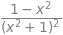

In [2]:
myFunction=1/(x+1/x)
myDerivative=sy.simplify(sy.diff(myFunction,x))
myDerivative

In [3]:
myDerivative.subs(x,2)

In [4]:
myFunction.subs(x,2)

Now we will do the same using a basic TPSA class. 

**DISCLAIMER**: this is a very naive application and not a fully fledged TPSA package. The goal is to propose the simplest example. We will consider **only** function from $\mathbb{R}$ to $\mathbb{R}$ like the one mentioned above. In addition we privileged the code clarity more than its speed.

## TPSA

We need to associate to our problem a vector representing the truncated power series of the function $f$. For instance the vector [$f(x_0)$, $\frac{df(x_0)}{dx}$] could represent the function and its first derivative evaluated in $x_0$. 
Up to this moment we set only a goal, now we can define a strategy.

The strategy is to replace a seed vector like [$x_0,\ 1$] (having the information of the starting point $x_0$ and representing the "TPSA differential") in our function such that after the "overloading" of the function we end up with the result [$f(x_0)$, $\frac{df(x_0)}{dx}$] by algebrically manipulation (that is without computing derivatives).

In other words we would like that our TPS algebra could compute 
\begin{equation}
\frac{1}{[2,1]+\frac{1}{[2,1]}}.
\end{equation}
and give as result the [$\frac{2}{5},\ -\frac{3}{25}$]. Clearly we need to define the concept of sum and division for our TPSA.

# The truncate method
We will use to represent [$f(x_0)$, $\frac{df(x_0)}{dx}$] a np.array. To condition the code we use the method "truncate" to avoid too short or too long np.array (the length of the np.array in our case HAS to be 2).

Here you are the proposed class:

In [5]:
class TPSA():  
    
    order=1
    
    def truncate(v1):
        # it takes list or np.array
        v1=np.array(v1)
        if len(v1)>(TPSA.order+1):
            return v1[0:(TPSA.order+1)]
        else:
            if len(v1)<(TPSA.order+1):
                return np.hstack((v1,np.zeros(TPSA.order+1-len(v1))))
            else:
                return v1;

In [6]:
# Example
TPSA.truncate([1])

array([1., 0.])

In [7]:
# Example
TPSA.truncate([2,3,4])

array([2, 3])

## The sum
We observe that 
\begin{equation}
a+b x + c +d x =(a+c) +(b+d) x.
\end{equation}
Therefore the sum of the TPSA space we want to compute has to be compliant with this results. That is 
\begin{equation}
[a,b] + [c, d]=[a+b, c+d].
\end{equation}
Here you are then the class we started to build extended with the additional method "sum". Note that we extend the previous class using the object inheritance.

In [8]:
class TPSA(TPSA):  
    def sum(v1,v2):
        # it takes list or np.array
        return TPSA.truncate(v1)+TPSA.truncate(v2)


In [9]:
# Example
TPSA.sum([2,3,4],[2])

array([4., 3.])

# The division
What do we expect from the operation of division?
$\frac{1}{[x_0,x_1]}$ should end up in [$\frac{1}{x_0}$,$-\frac{x_1}{x_0^2}$]. This is a simple approach that can be extended to all unary (single operand) operator.

In [10]:
class TPSA(TPSA):  
    def divide(v1):
        v1=TPSA.truncate(v1)
        return np.array([1/v1[0],-v1[1]/v1[0]**2])

In [11]:
# Example
TPSA.divide([2,1])

array([ 0.5 , -0.25])

## Putting all together

Here you are the TPSA version of
\begin{equation}
f(x)=\frac{1}{x+\frac{1}{x}}
\end{equation}
in $x_0=2$.

In [12]:
x=[2,1]
TPSA.divide(TPSA.sum(x,TPSA.divide(x)))

array([ 0.4 , -0.12])

We therefore find exactly the expected result.
Have a look to the following examples and tests.

In [13]:
x=[2,2]
TPSA.divide(TPSA.sum(x,TPSA.divide(x)))

array([ 0.4 , -0.24])

In [14]:
x=[1,0]
TPSA.divide(TPSA.sum(x,TPSA.divide(x)))

array([ 0.5, -0. ])

A proper way to do things would be define a new type (class) and overload also "+","-","*",...
https://realpython.com/operator-function-overloading/


In [15]:
class TPSA():   
    def __init__(self, TPSA_vector):
        self.order=1
        self.vector =  self.__truncate__(TPSA_vector)
    
    def __truncate__(self,v1):
        # it takes list or np.array
        v1=np.array(v1)
        if len(v1)>(self.order+1):
            return v1[0:(self.order+1)]
        else:
            if len(v1)<(self.order+1):
                return np.hstack((v1,np.zeros(self.order+1-len(v1))))
            else:
                return v1;
            
    def __add__(self,v2):
        # it takes list or np.array
        return TPSA(self.vector+self.__truncate__(v2.vector))
    
    def __invert__(self):
        return TPSA(np.array([1./self.vector[0],-self.vector[1]/self.vector[0]**2]))

In [16]:
# Note that the unary inversion in Python is ~
x=TPSA([2,1])
(~(x+~x)).vector

array([ 0.4 , -0.12])